In [ ]:
# pip installs

!pip install -q datasets peft requests torch bitsandbytes transformers trl accelerate sentencepiece matplotlib

In [ ]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [ ]:
BASE_MODEL = "meta-llama/Llama-3.2-3B-Instruct"
PROJECT_NAME = "pricer"
HF_USER = "Rohit-9898"

# encodings_to_try = ['latin1', 'utf-8', 'cp1252', 'iso-8859-1']

# train_loaded = False
# for encoding in encodings_to_try:
#     try:
#         with open("train.pkl", "rb") as f:
#             train = pickle.load(f, encoding=encoding)
#         train_loaded = True
#         print(f"Successfully loaded 'train.pkl' using encoding: {encoding}")
#         break  # Stop if successful
#     except UnicodeDecodeError as e:
#         print(f"Error loading 'train.pkl' with encoding {encoding}: {e}")

DATASET_NAME = "rohitsharma77/lite-data"
MAX_SEQUENCE_LENGTH = 182

# Run name for saving the model in the hub


RUN_NAME =  f"2025-05-16_03.04.39"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"
REVISION = None

FINETUNED_MODEL = f"{rohitsharma77/pricer-2025-05-06_04.12.09}"

# Hyperparameters for QLoRA

LORA_R = 8
LORA_ALPHA = 16
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True # change this to quantize to 8 bits (larger)

# Hyperparameters for Training

EPOCHS = 1 # only 1 is needed more is probably overkill
BATCH_SIZE = 1 # increase if more GPU power
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

DATASET_NAME = "rohitsharma77/pricer-data"

# note that SAVE_STEPS is how often it will upload to the hub
# 2000 so that you get more frequent saves

STEPS = 50
SAVE_STEPS = 2000
# LOG_TO_WANDB = True

%matplotlib inline
QUANT_4_BIT = True

%matplotlib inline

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [ ]:
# Log in to HuggingFace
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [ ]:
# pick the right quantization (thank you Robert M. for spotting the bug with the 8 bit version!)

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
# Load the Tokenizer and the Model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="cuda:0",
)

base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5700.6 MB


In [ ]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
extract_price("Price is $a fabulous 899.99 or so")

899.99

In [ ]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [ ]:
# An improved prediction function takes a weighted average of the top 3 choices

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [ ]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $373.50 Truth: $374.41 Error: $0.91 SLE: 0.00 Item: OEM AC Compressor w/...
2: Guess: $160.62 Truth: $225.11 Error: $64.49 SLE: 0.11 Item: Motorcraft YB3125 Fa...
3: Guess: $40.09 Truth: $61.68 Error: $21.59 SLE: 0.18 Item: Dorman Front Washer ...
4: Guess: $415.75 Truth: $599.99 Error: $184.24 SLE: 0.13 Item: HP Premium HD Plus T...
5: Guess: $18.31 Truth: $16.99 Error: $1.32 SLE: 0.01 Item: Super Switch Pickup ...
6: Guess: $16.94 Truth: $31.99 Error: $15.05 SLE: 0.37 Item: Horror Bookmarks, Re...
7: Guess: $116.62 Truth: $101.79 Error: $14.83 SLE: 0.02 Item: SK6241 - Stinger 4 G...
8: Guess: $297.00 Truth: $289.00 Error: $8.00 SLE: 0.00 Item: Godox ML60Bi LED Lig...
9: Guess: $860.50 Truth: $635.86 Error: $224.64 SLE: 0.09 Item: Randall G3 Plus Comb...
10: Guess: $65.75 Truth: $65.99 Error: $0.24 SLE: 0.00 Item: HOLDWILL 6 Pack LED ...
11: Guess: $214.75 Truth: $254.21 Error: $39.46 SLE: 0.03 Item: Viking Horns 3 Gallo...
12: Guess: $381.50 Truth: $412.99 Error: $31.49 SLE

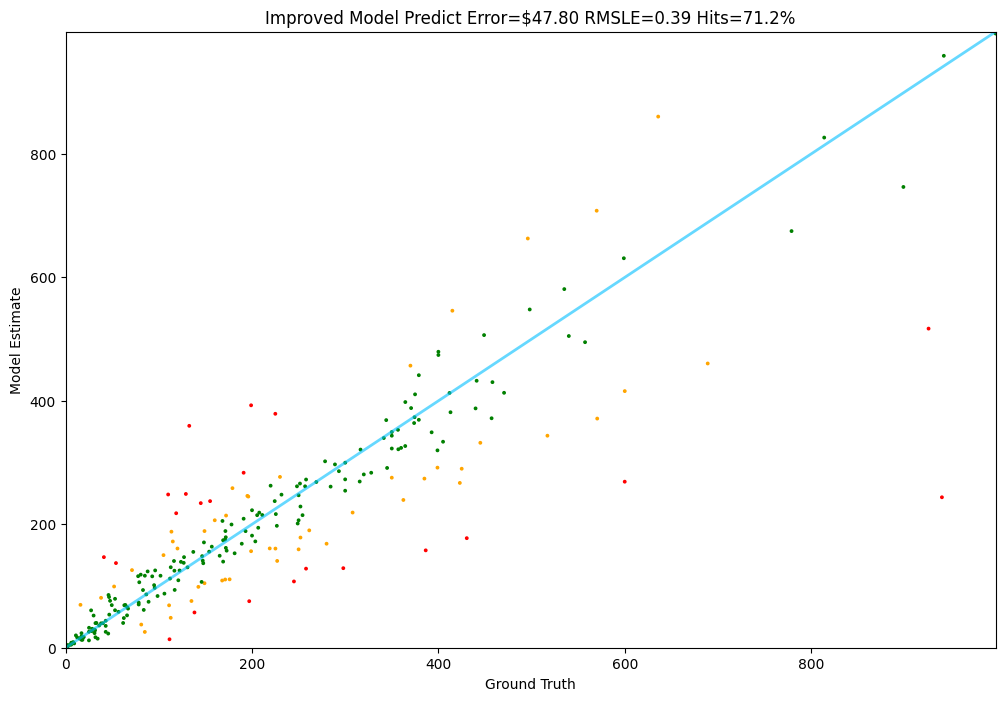

In [ ]:
Tester.test(improved_model_predict, test)